In [2]:
import os

import scipy 
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from hamilton import driver
import torch
from tensordict import TensorDict

from world_machine_experiments import  shared
from world_machine_experiments.toy1d import base

In [3]:
from world_machine_experiments.toy1d.base.data import _observation_matrix, _state_control, _state_transition_matrix, _periodic_state_control
from world_machine_experiments.toy1d.base.dataset import Toy1dDataset

from world_machine.data import WorldMachineDataset

In [4]:
generator = np.random.default_rng(0)

In [5]:
measurement_size = 2
n_sequence = 10000
sequence_length = 1000
context_size = 200
state_control = "periodic"

In [61]:
H = _observation_matrix(generator, measurement_size)  # NOSONAR
F = _state_transition_matrix()

# print(H)

# Sequence generation
state = (2*generator.random((n_sequence, 3)))-1

states = np.empty((sequence_length, n_sequence, 3))
state_controls = np.empty((sequence_length, n_sequence, 3))

control_state = {}

for i in range(sequence_length):
    state: np.ndarray = np.dot(
        F, state.reshape(-1, 3).T).T.reshape(state.shape)

    if state_control is not None:
        if state_control == "random":
            Gu = _state_control(state, generator)  # NOSONAR
        elif state_control == "periodic":
            Gu = _periodic_state_control(
                state, generator, i, control_state, sequence_length)

        state += Gu
        state_controls[i] = Gu

    state[1] = np.clip(state[1], -1, 1)
    state[2] = np.clip(state[2], -1, 1)

    states[i] = state

# States
states = np.transpose(states, (1, 0, 2))

state_max = states[:, :, 0].max()
state_min = states[:, :, 0].min()

states = (states - state_min)/(state_max-state_min)
states = 2*(states-0.5)

# State Controls
state_controls = np.transpose(state_controls, (1, 0, 2))

# Measurements
measurements = np.dot(
    H, states.reshape(-1, 3).T).T.reshape((n_sequence, sequence_length, measurement_size))

measurements = (measurements-state_min)/(state_max-state_min)
measurements = (2*measurements)-1

measurements = np.tanh(0.1*measurements)

data = {"state_decoded": states, "state_control": state_controls,
        "next_measurement": measurements}



In [62]:
class Toy1dDataset(WorldMachineDataset):
    def __init__(self, data: dict[str, np.ndarray], context_size: int,
                 return_state_dimensions: list[int] | None = None):

        self._data = data
        self._context_size = context_size
        self._return_dimensions = return_state_dimensions

        self._n_sequence = self._data["state_decoded"].shape[0]
        self._sequence_size = self._data["state_decoded"].shape[1]
        self._items_in_sequence = (self._sequence_size-1)//self._context_size

        size = self._n_sequence*int((self._sequence_size-1)/context_size)

        super().__init__(
            ["state_control", "next_measurement"],
            size=size,
            has_state_decoded=True,
            has_masks=False)

    def get_dimension_item(self, dimension: str, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        item_index = index // self._items_in_sequence
        item_seq_index = index % self._items_in_sequence

        start = item_seq_index*self._context_size
        end = start+self._context_size

        state_decoded = self._data["state_decoded"][item_index, start:end+1][:, 0]
        s_max = state_decoded.max()
        s_min = state_decoded.min()

        item = []

        for i in range(2):
            item.append(torch.Tensor(
                self._data[dimension][item_index, start+i:end+i]))
                

            if self._return_dimensions is not None and dimension == "state_decoded":
                item[i] = item[i][:, self._return_dimensions]

            item[i] = (item[i]-s_min)/(s_max-s_min)
            item[i] = (2*item[i])-1

        return item

In [63]:
dataset = Toy1dDataset(data, context_size)

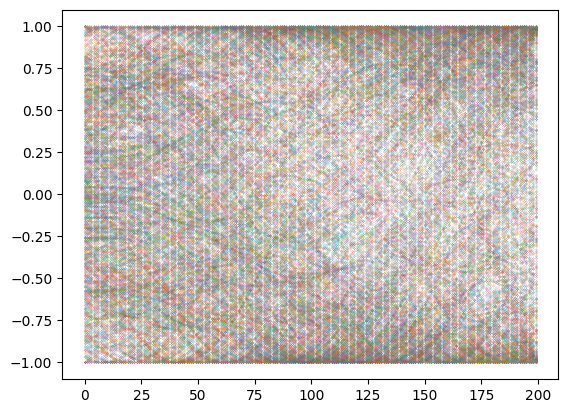

In [64]:
for i in range(1000):
    plt.plot(dataset[i]["inputs"]["state_decoded"][:,0], "o", markersize=.1)

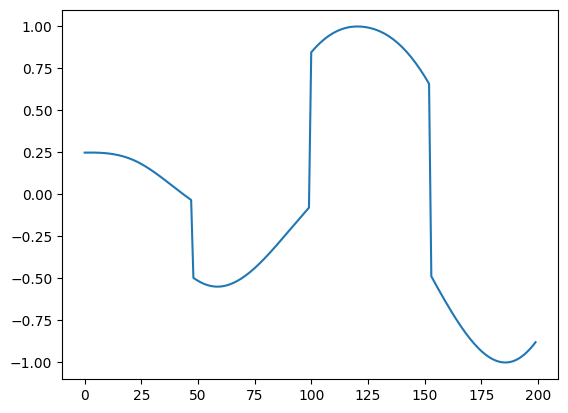

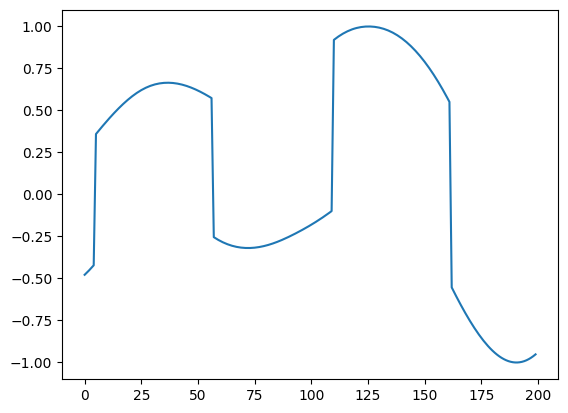

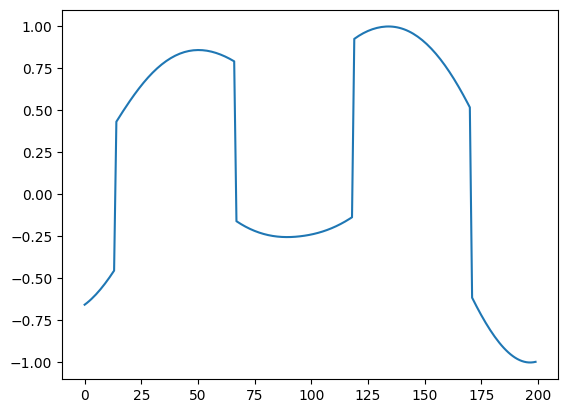

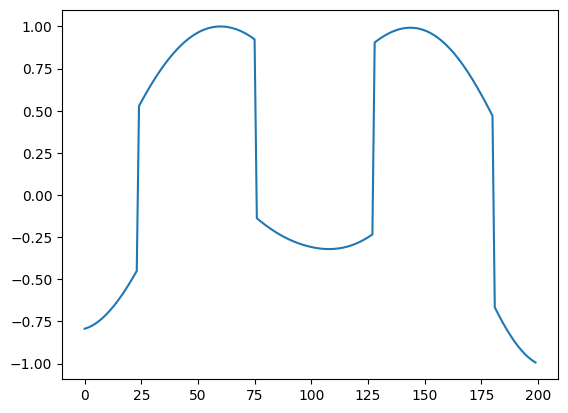

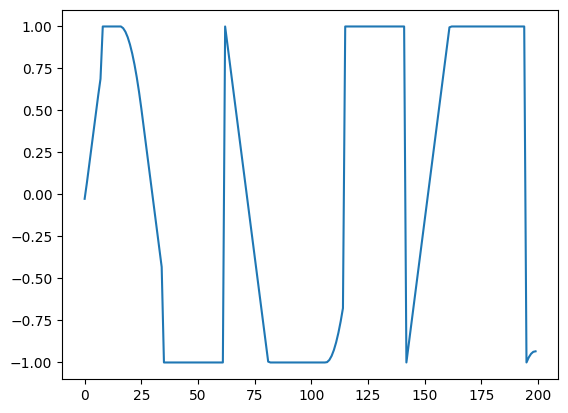

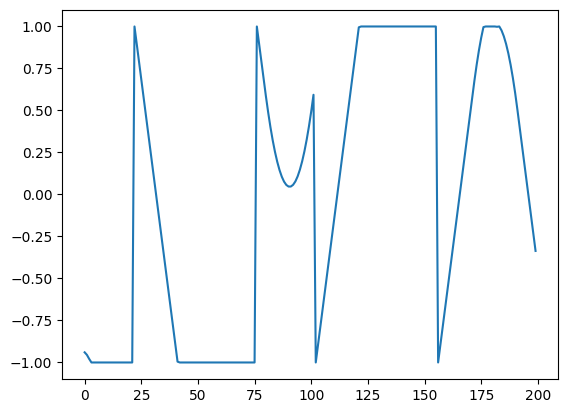

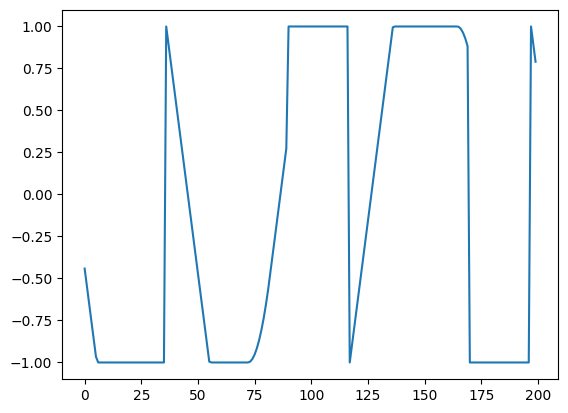

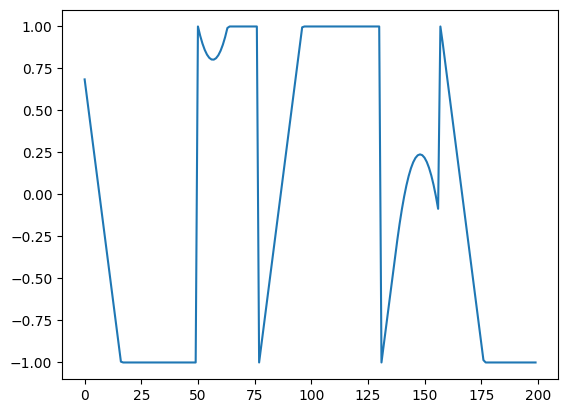

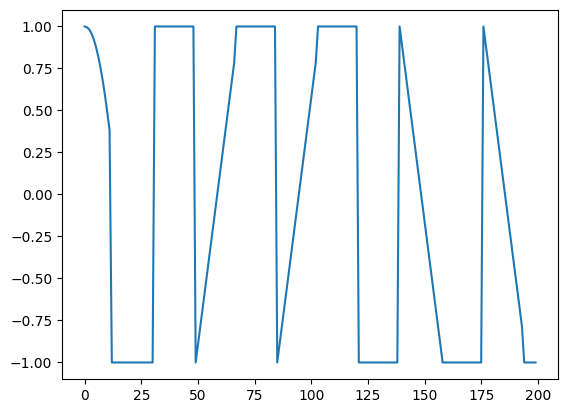

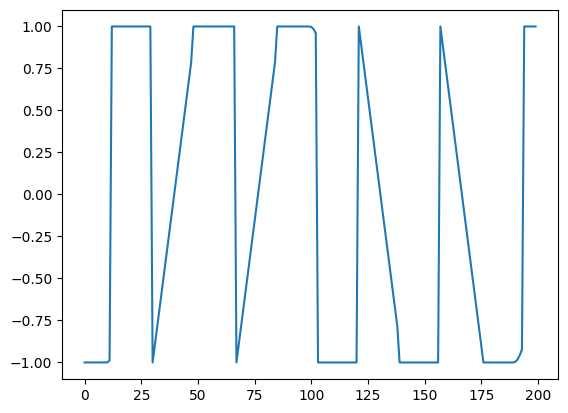

In [65]:
for i in range(10):
    plt.plot(dataset[i]["inputs"]["state_decoded"][:,0])
    plt.show()

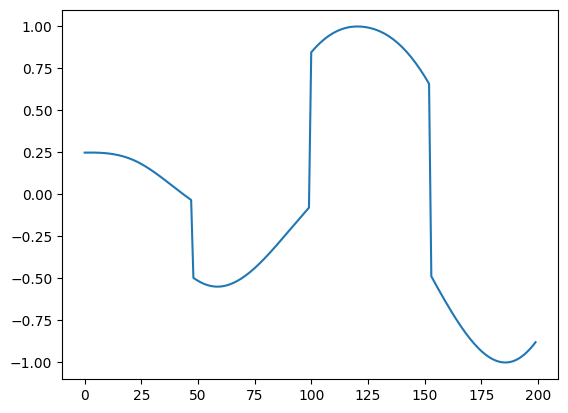

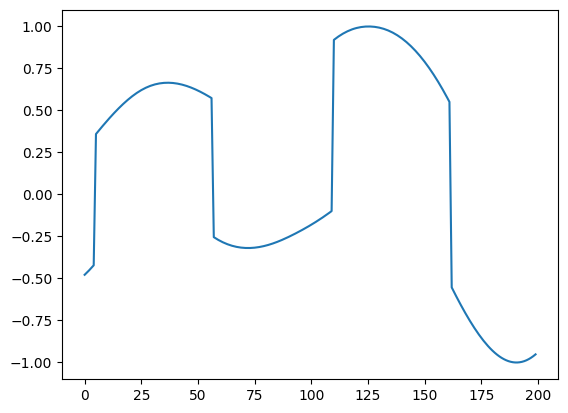

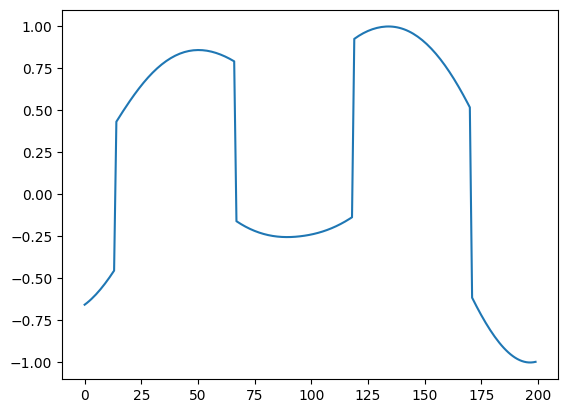

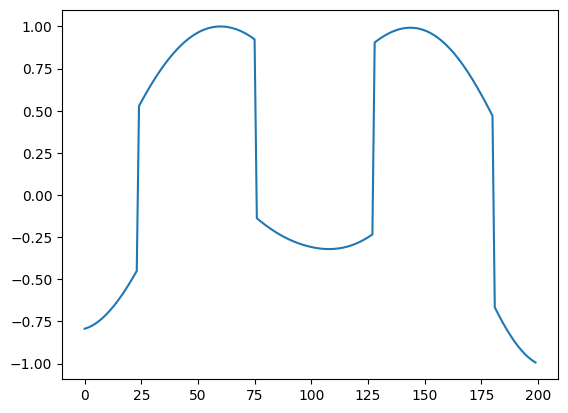

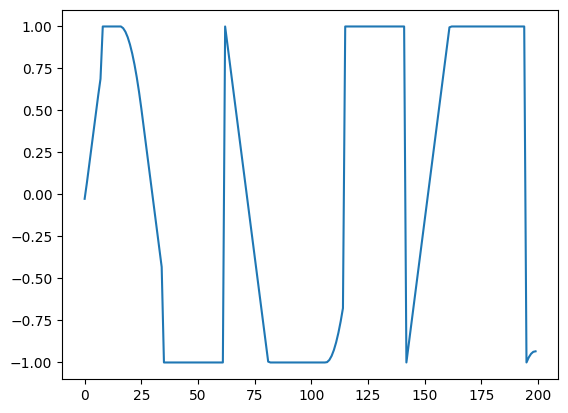

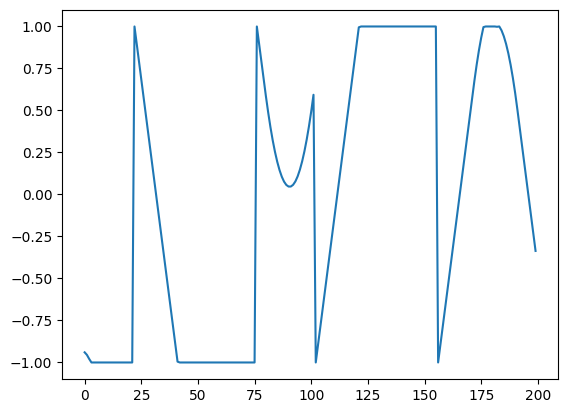

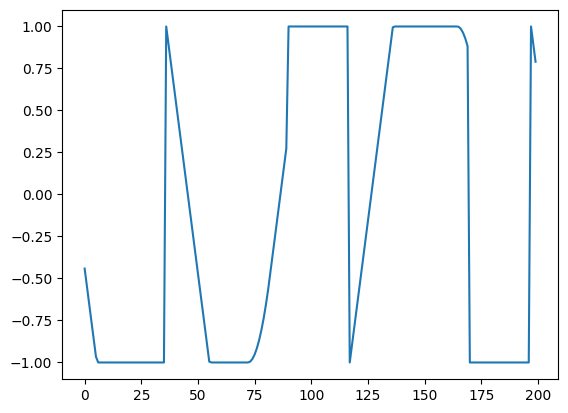

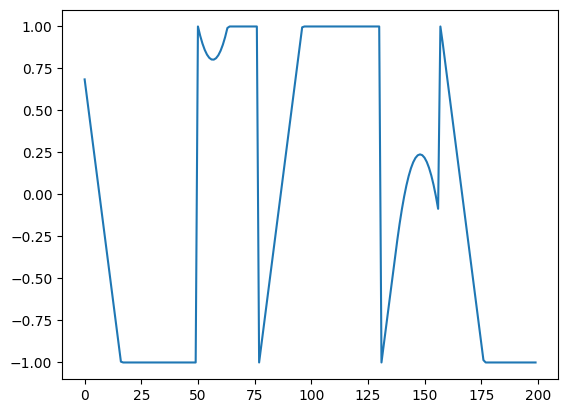

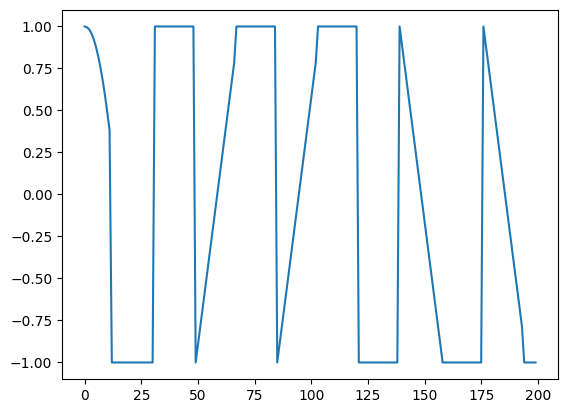

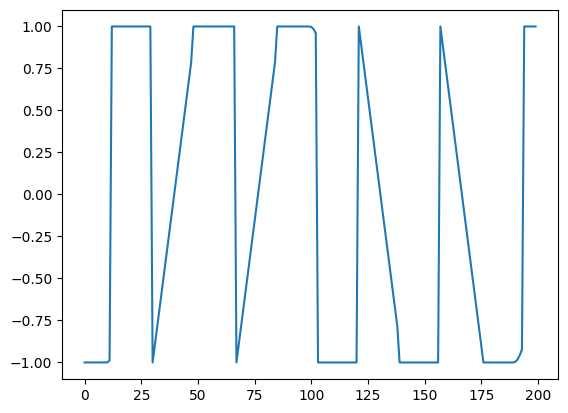

In [66]:
for i in range(10):
    plt.plot(dataset[i]["inputs"]["state_decoded"][:,0])
    plt.show()

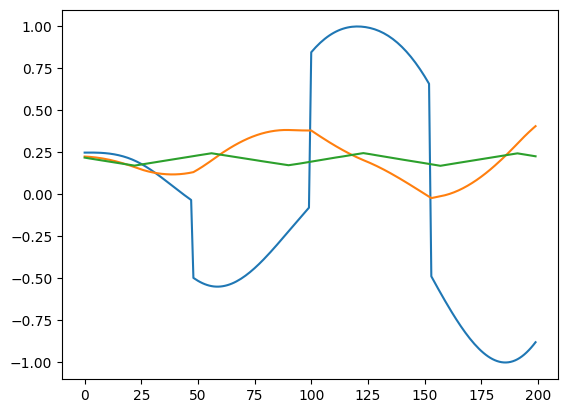

In [67]:
for i in range(3):
    plt.plot(dataset[0]["inputs"]["state_decoded"][:,i])

0


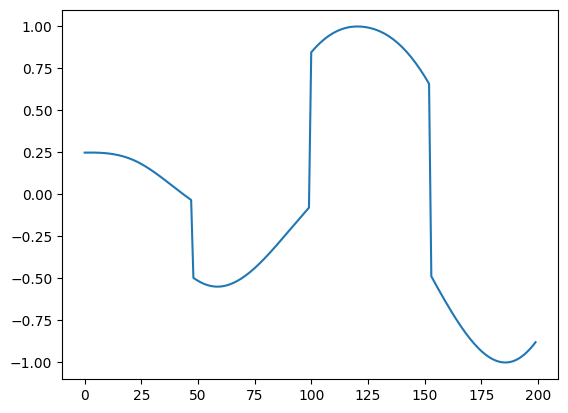

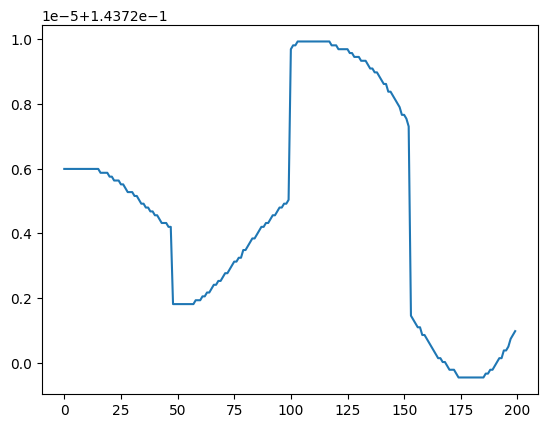

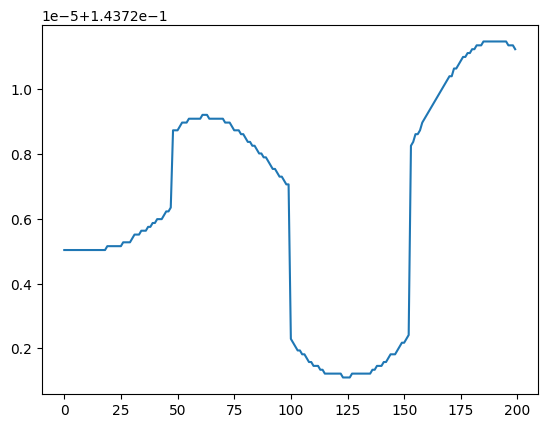

1


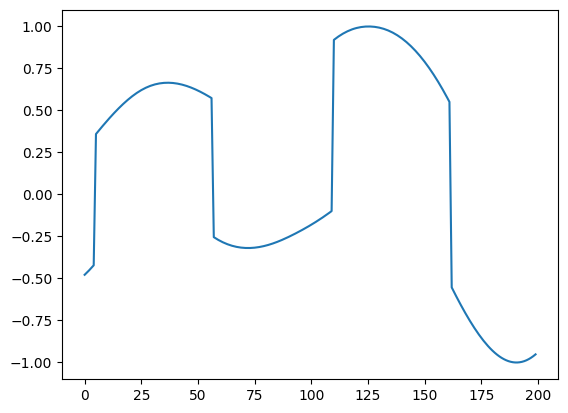

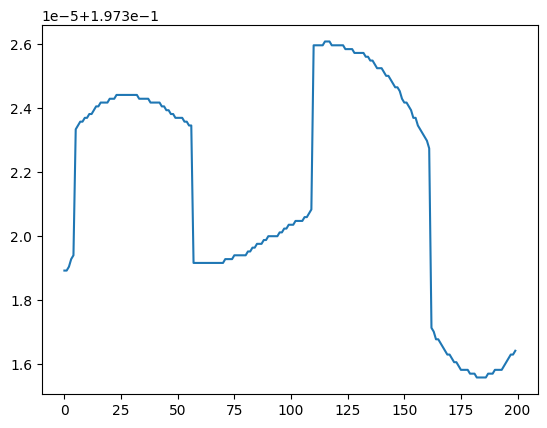

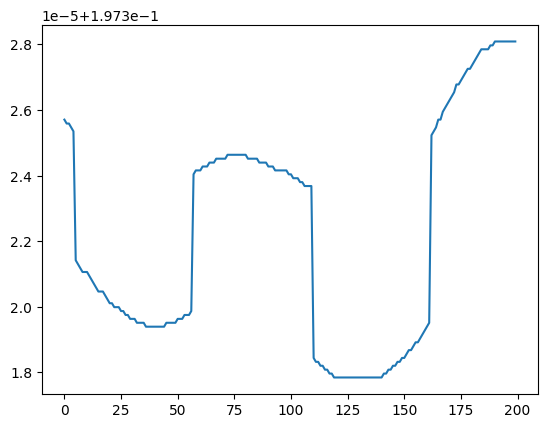

2


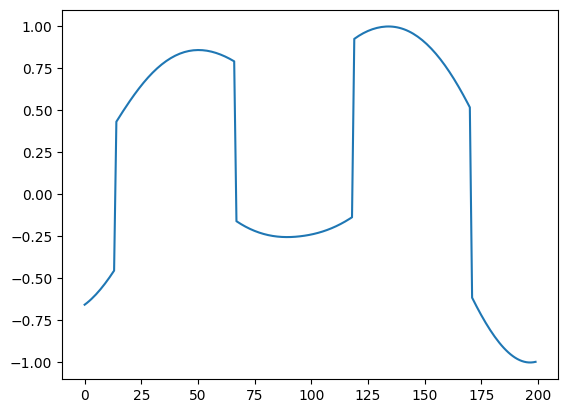

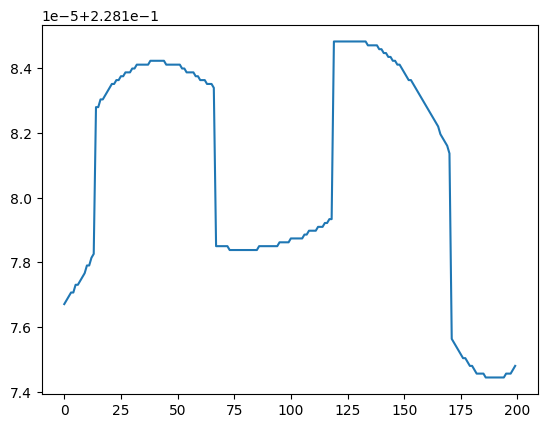

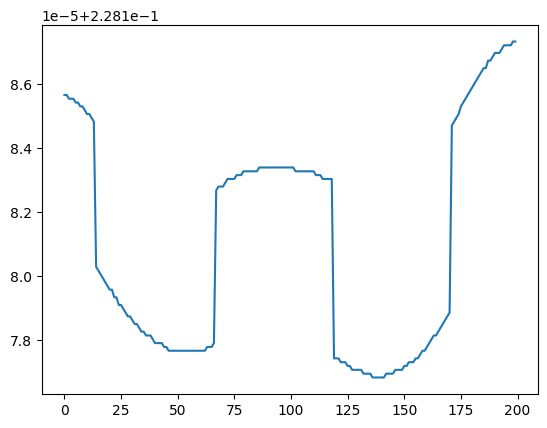

3


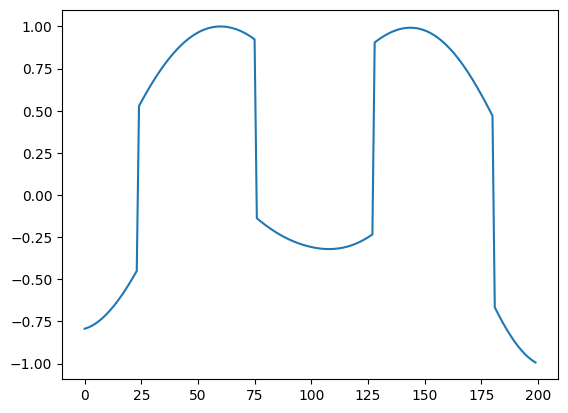

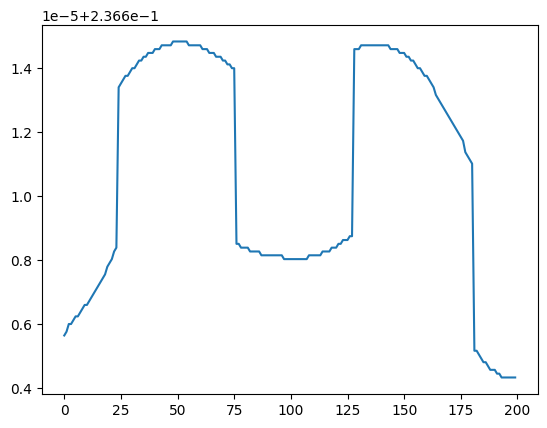

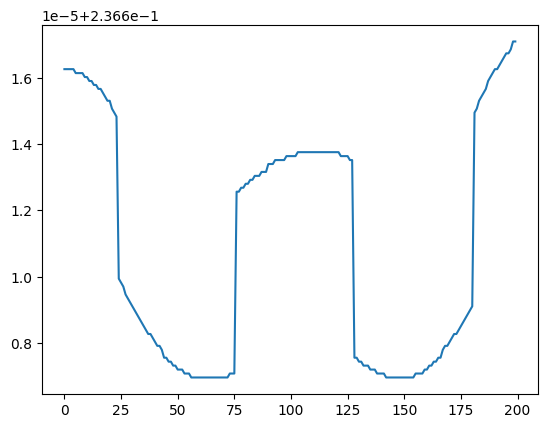

4


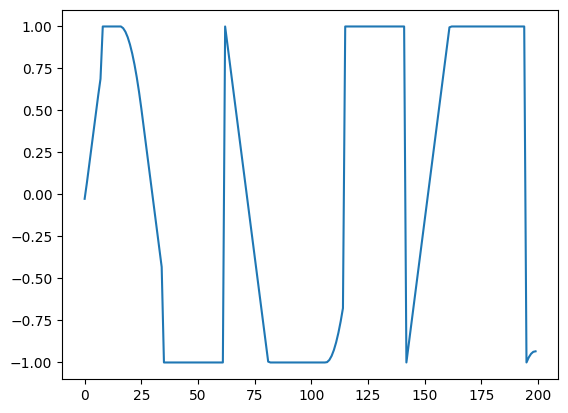

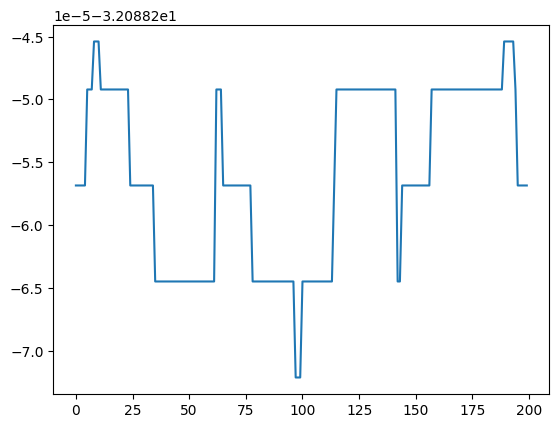

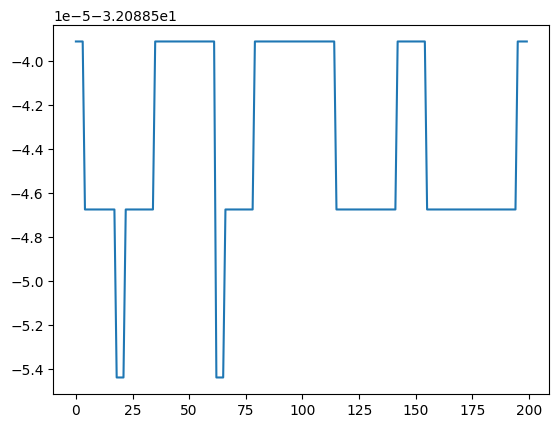

5


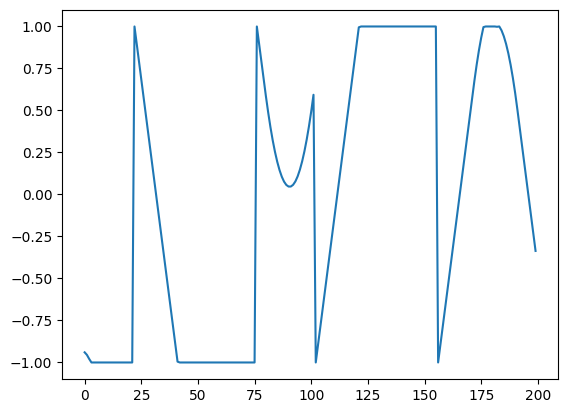

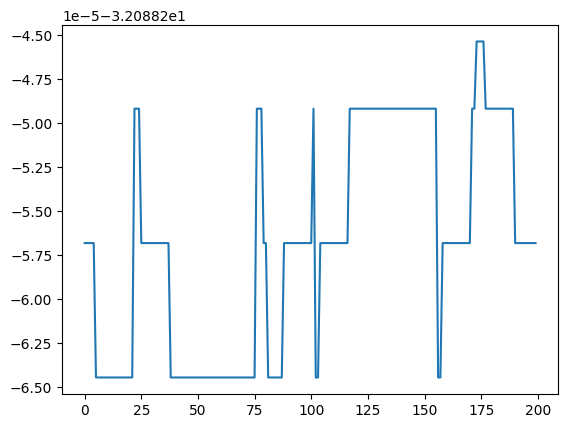

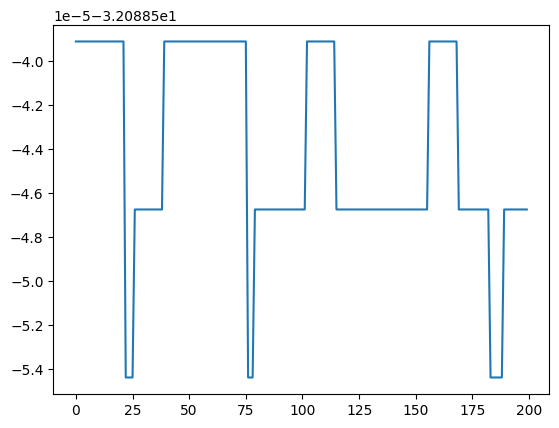

6


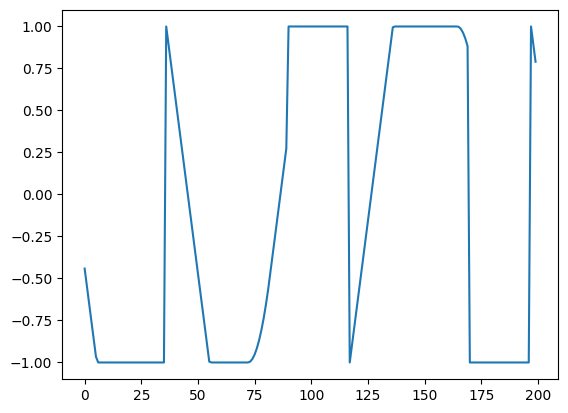

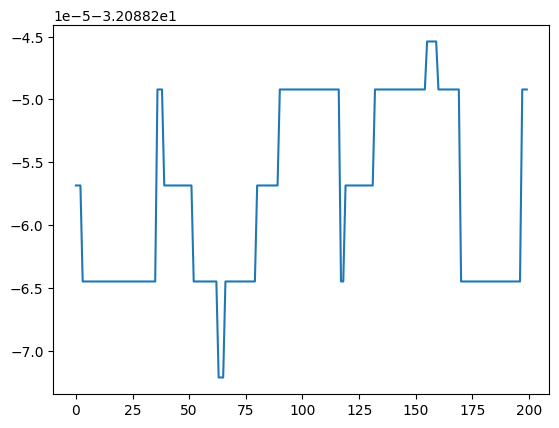

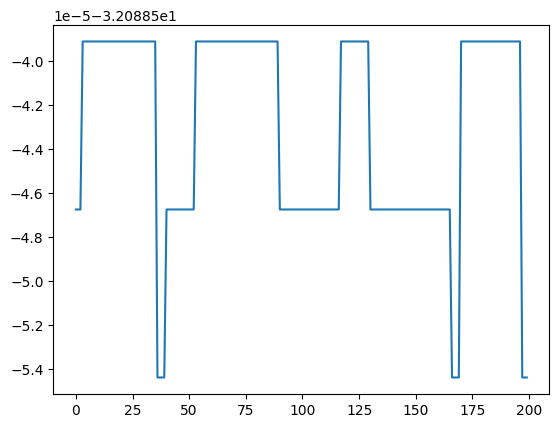

7


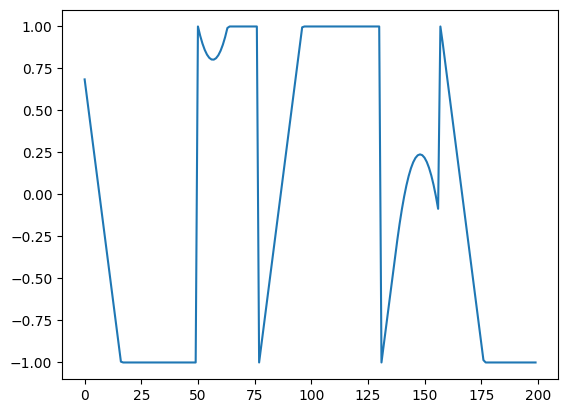

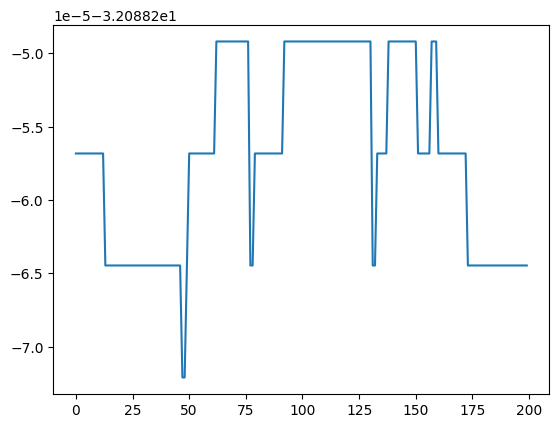

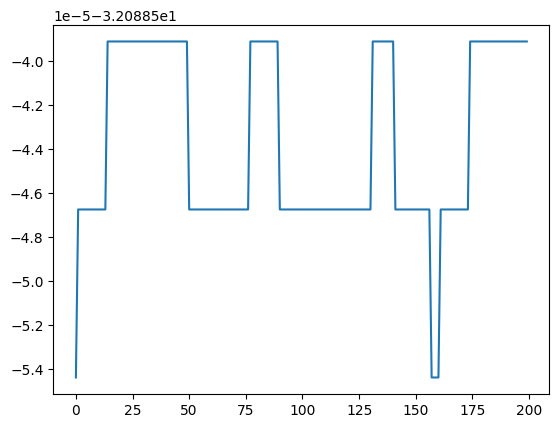

8


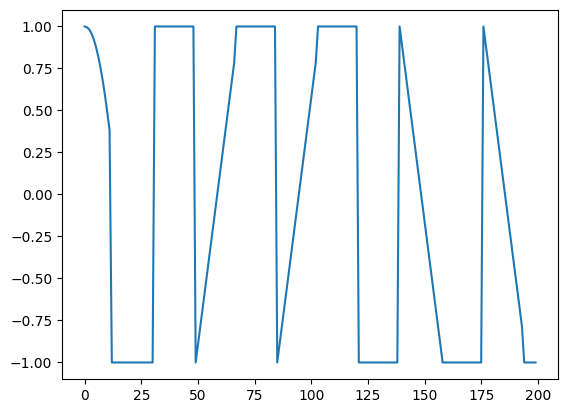

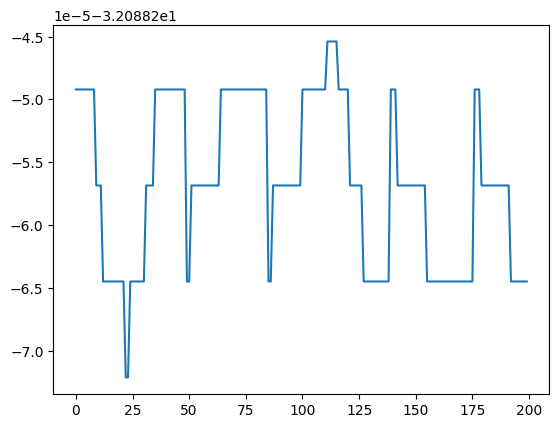

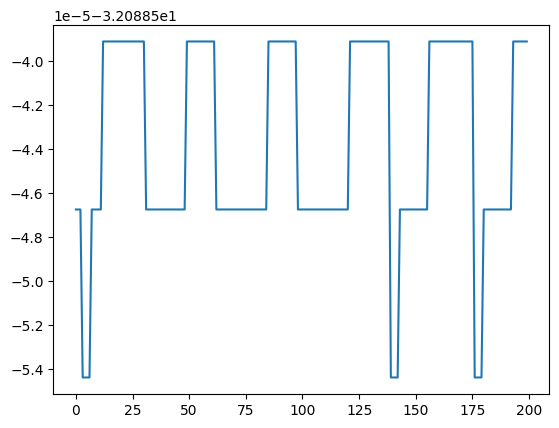

9


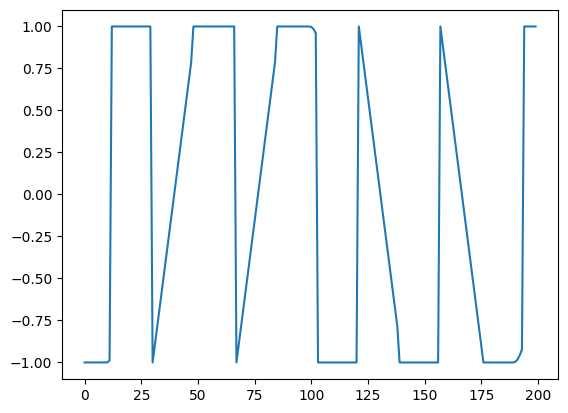

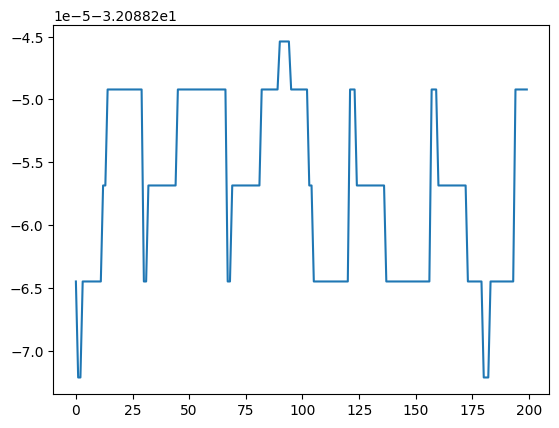

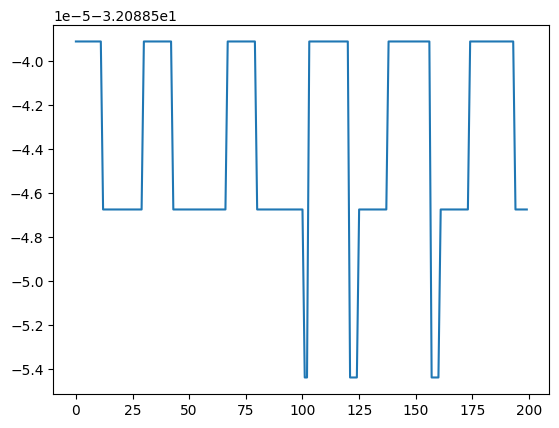

In [68]:
for i in range(10):

    print(i)
    plt.plot(dataset[i]["inputs"]["state_decoded"][:,0])
    plt.show()
    plt.plot(dataset[i]["inputs"]["next_measurement"][:,0])
    plt.show()
    plt.plot(dataset[i]["inputs"]["next_measurement"][:,1])
    plt.show()
